**Update the package information**

In [1]:
!apt-get update

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:4 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Ign:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:8 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [696 B]
Hit:10 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:11 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Hit:12 http://ppa.launchpad.net/cran/libgit2/u

**Install useful programs** 

In [2]:
!apt-get install tcpdump 
!apt-get install dnsutils
!apt-get install wireshark-common
!apt-get install tshark

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libpcap0.8
Suggested packages:
  apparmor
The following NEW packages will be installed:
  libpcap0.8 tcpdump
0 upgraded, 2 newly installed, 0 to remove and 42 not upgraded.
Need to get 482 kB of archives.
After this operation, 1,408 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libpcap0.8 amd64 1.8.1-6ubuntu1.18.04.2 [118 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 tcpdump amd64 4.9.3-0ubuntu0.18.04.2 [364 kB]
Fetched 482 kB in 0s (1,806 kB/s)
Selecting previously unselected package libpcap0.8:amd64.
(Reading database ... 155455 files and directories currently installed.)
Preparing to unpack .../libpcap0.8_1.8.1-6ubuntu1.18.04.2_amd64.deb ...
Unpacking libpcap0.8:amd64 (1.8.1-6ubuntu1.18.04.2) ...
Selecting previously unselected package tcpdump.
Prepari

**Uploading phase**

In [3]:
from google.colab import files

print('Upload a CSV file named "websites.csv" with one target for each line.')
files.upload()
print('Upload a script in Bash named "dataset.sh" able to construct the dataset ("capture.pcap").')
files.upload()

Upload a CSV file named "websites.csv" with one target for each line.


Saving dataset.sh to dataset.sh
Upload a script in Bash named "dataset.sh" able to construct the dataset ("capture.pcap").


Saving websites.csv to websites.csv


{'websites.csv': b'https://www.indiatimes.com/\r\nhttps://www.washingtonpost.com/\r\nhttps://www.ndtv.com/\r\nhttps://www.cnbc.com/\r\nhttps://www.timesofindia.com/\r\nhttps://www.express.co.uk/\r\nhttps://www.rt.com/\r\nhttps://www.news18.com/\r\nhttps://www.nypost.com/\r\nhttps://www.abc.net.au/\r\nhttps://www.bbc.co.uk/\r\nhttps://www.msn.com/\r\nhttps://www.cnn.com/\r\nhttps://www.news.google.com/\r\nhttps://www.dailymail.co.uk/\r\nhttps://www.nytimes.com/\r\nhttps://www.theguardian.com/\r\nhttps://www.foxnews.com/\r\nhttps://www.finance.yahoo.com/\r\nhttps://www.news.yahoo.com/\r\n'}

**Perform the necessary requests**

In [4]:
!bash dataset.sh

Input host: https://www.indiatimes.com/
Cleaned host: www.indiatimes.com
tcpdump: listening on eth0, link-type EN10MB (Ethernet), capture size 262144 bytes
231 packets captured
260 packets received by filter
0 packets dropped by kernel
tcpdump: listening on eth0, link-type EN10MB (Ethernet), capture size 262144 bytes
173 packets captured
191 packets received by filter
0 packets dropped by kernel
tcpdump: listening on eth0, link-type EN10MB (Ethernet), capture size 262144 bytes
215 packets captured
225 packets received by filter
0 packets dropped by kernel
tcpdump: listening on eth0, link-type EN10MB (Ethernet), capture size 262144 bytes
194 packets captured
202 packets received by filter
0 packets dropped by kernel
tcpdump: listening on eth0, link-type EN10MB (Ethernet), capture size 262144 bytes
166 packets captured
184 packets received by filter
0 packets dropped by kernel
tcpdump: listening on eth0, link-type EN10MB (Ethernet), capture size 262144 bytes
185 packets captured
209 pack

**Extract biflow features from each capture**
* Num packets up/down
* Total bytes up/down
* Min/max/mean/std packet size up/down
* Min/max/mean/std IAT up/down


We used:

*   Direction "0" for downlink
*   Direction "1" for uplink



In [65]:
import pandas as pd
from os import listdir
from os.path import isfile, join
import numpy as np
from google.colab import drive


def extract_features(df_flow, filename, direction):
  # flow_features dictionary
  flow_features = {}

  flow_features['direction'] = direction

  # Defininf the flow_features keys (features)
  flow_features['num_packets'] = len(df_flow)

  pkt_sizes = df_flow['frame.len'].astype(float)
  flow_features['mean_pkt_size'] = pkt_sizes.mean()
  flow_features['max_pkt_size'] =  pkt_sizes.max()
  flow_features['min_pkt_size'] = pkt_sizes.min()
  flow_features['total_bytes'] = pkt_sizes.sum()
  flow_features['std_pkt_size'] = pkt_sizes.std()

  # iat = inter arrival times
  # .diff(1) = difference between two consecutive entries
  # .dt.total_seconds() = convert the difference into seconds
  # .ilock[1:] = do the ".diff" from the second entry
  iat = pd.to_datetime(df_flow['frame.time']).diff(1).dt.total_seconds().iloc[1:]
  flow_features['min_iat'] = iat.min()
  flow_features['max_iat'] = iat.max()
  flow_features['mean_iat'] = iat.mean()
  flow_features['std_iat'] = iat.std()
  flow_features['dur'] = iat.sum()

  flow_features['website'] = filename.split('_')[1]

  return flow_features

# n is the number of "curl request" to evaluate, max value: 10
def first_dataset(n):
  #drive.mount('/content/drive')
  #path = '/content/drive/MyDrive/Colab Notebooks/Last with ack info'
  path = '/content/captures'

  dumpfiles = [f for f in listdir(path) if (isfile(join(path, f)))]
  websites = np.unique([f.split('_')[1] for f in dumpfiles])

  dataset = pd.DataFrame()
  for f in dumpfiles:
    if ".pcap" in f:
      continue
    testnumber = (f.split('_')[2]).replace(".csv", "")
    if int(testnumber) > n:
      continue
    df = pd.read_csv(join(path, f))
    
    # Alternative way to do casting, I tried "df_down = pd.DataFrame()" but it doesn't work
    df_down = df[df["ip.proto"]==0]
    df_up = df[df["ip.proto"]==0]

    for id, ip in enumerate(df['ip.src']):
      src_ip_octets = ip.split('.')
      if(src_ip_octets[0]=='10' or (src_ip_octets[0]=='172' and src_ip_octets[1]>='16' and src_ip_octets[1]<='31') 
      or (src_ip_octets[0]=='192' and src_ip_octets[1]=='168')):
        df_up = df_up.append(df.loc[id])
      else:
        df_down = df_down.append(df.loc[id])

    # Direction "0" for downlink
    flow_features_down = extract_features(df_down, f, 0)
    # Direction "1" for uplink
    flow_features_up = extract_features(df_up, f, 1)
    dataset = dataset.append(flow_features_up, ignore_index=True)
    dataset = dataset.append(flow_features_down, ignore_index=True)
  return dataset

first_dataset_10 = first_dataset(10)
display(first_dataset_10)

,direction,num_packets,mean_pkt_size,max_pkt_size,min_pkt_size,total_bytes,std_pkt_size,min_iat,max_iat,mean_iat,std_iat,dur,website
0,1.0,51.0,220.235294,1240.0,66.0,11232.0,310.808017,0.000003,3.330123,0.139950,0.537107,6.997490,www.rt.com
1,0.0,17.0,2525.352941,17442.0,66.0,42931.0,4584.893278,0.000004,0.983729,0.097003,0.243334,1.552042,www.rt.com
2,1.0,20.0,404.600000,1294.0,66.0,8092.0,443.043826,0.000008,2.437756,0.251118,0.673391,4.771238,www.dailymail.co.uk
3,0.0,2.0,196.000000,216.0,176.0,392.0,28.284271,0.080367,0.080367,0.080367,NaN,0.080367,www.dailymail.co.uk
4,1.0,151.0,206.927152,1459.0,66.0,31246.0,291.746833,0.000000,2.562256,0.037076,0.222959,5.561417,www.indiatimes.com
...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,0.0,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.000000,www.theguardian.com
396,1.0,88.0,153.636364,1176.0,66.0,13520.0,228.336724,0.000003,3.774244,0.055942,0.411744,4.866920,www.ndtv.com
397,0.0,56.0,4172.642857,13098.0,66.0,233668.0,3568.749164,0.000002,0.018387,0.001731,0.003679,0.095229,www.ndtv.com
398,1.0,78.0,162.230769,1240.0,66.0,12654.0,261.476324,0.000004,2.339037,0.064457,0.348123,4.963190,www.cnn.com


**k-NN** classifier

In [76]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay

def knn_classifier(MAX_neighbors, data_set):
  scaler = StandardScaler();

  # Drop the rows where at least one element is missing.
  X = data_set.dropna()

  # Extract the last column and then drop it, now X contains only numbers
  Y = X['website'];
  X = X.drop(['website'], axis=1).dropna()

  X_norm = scaler.fit_transform(X);

  # Split into train set and test set
  X_train, X_test, Y_train, Y_test = train_test_split(X_norm, Y, test_size=0.30)

  ACCURACY = []
  PREDICTIONS = []

  MAX_neighbors=10
  for k in range(1,MAX_neighbors+1):
    knn = KNeighborsClassifier(n_neighbors=k, weights='distance')
    knn.fit(X_train, Y_train)
    knn_predict = knn.predict(X_test)
    accuracy = accuracy_score(Y_test, knn_predict)
    ACCURACY.append(accuracy)
    PREDICTIONS.append(knn_predict)
    print(k, accuracy)
  return ACCURACY, PREDICTIONS, Y_test

MAX_neighbors=10
ACCURACY_first_10, PREDICTIONS_first_10, Y_test_first_10 = knn_classifier(MAX_neighbors, first_dataset_10)

1 0.5769230769230769
2 0.5769230769230769
3 0.5673076923076923
4 0.5673076923076923
5 0.5673076923076923
6 0.5961538461538461
7 0.5673076923076923
8 0.5576923076923077
9 0.5576923076923077
10 0.5673076923076923


**Accuracy-Neighbors** graph

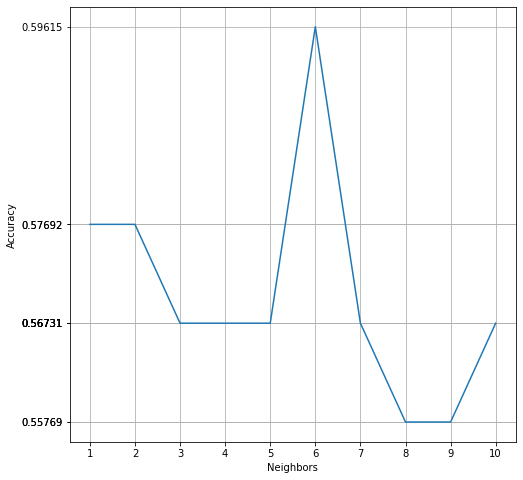

In [77]:
def accuracy_neighbors_graph(ACCURACY, max_neighbors):
  fig = plt.figure(figsize=(8,8))
  # Histogram divided into 150 intervals
  x = range(1,max_neighbors+1)
  y = ACCURACY
  plt.plot(x, y)
  plt.grid(visible=True)
  plt.xlabel('Neighbors')
  plt.ylabel('Accuracy')
  plt.xticks(x)
  plt.yticks(y)

accuracy_neighbors_graph(ACCURACY_first_10, MAX_neighbors)

**ConfusionMatrixDisplay** with the highest level of accuracy

ConfusionMatrixDisplay for k=5 accuracy=0.5961538461538461



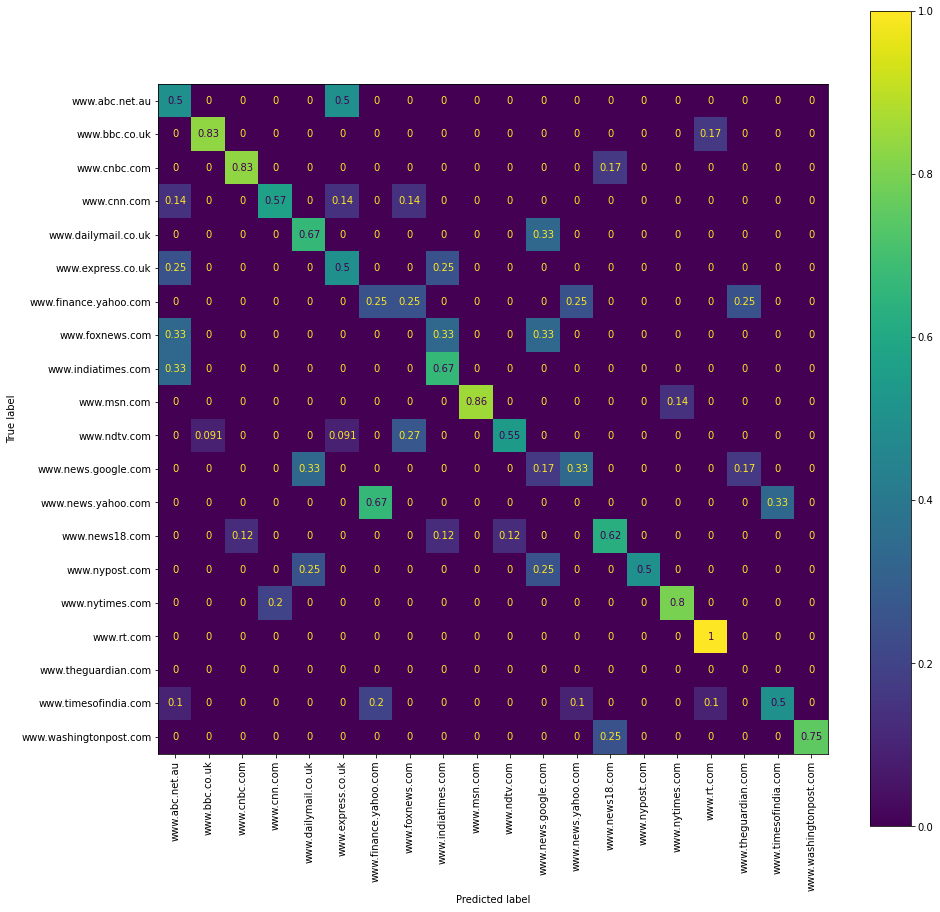

In [78]:
def ConfusionMatrixDisplay_fun(ACCURACY, PREDICTIONS, Y_test):
  index = np.argmax(ACCURACY)
  max_accuracy = ACCURACY[index]
  print("ConfusionMatrixDisplay for k=" + str(index)+ " accuracy=" +str(max_accuracy)+"\n")
  fig, ax = plt.subplots(figsize=(15, 15))
  ConfusionMatrixDisplay.from_predictions(PREDICTIONS[index], Y_test, ax=ax, normalize='true', xticks_rotation='vertical')

ConfusionMatrixDisplay_fun(ACCURACY_first_10, PREDICTIONS_first_10, Y_test_first_10)

**SAME EXECUTED WITH ONLY 3 TESTS**

1 0.34375
2 0.34375
3 0.34375
4 0.34375
5 0.34375
6 0.34375
7 0.34375
8 0.34375
9 0.34375
10 0.34375
ConfusionMatrixDisplay for k=0 accuracy=0.34375



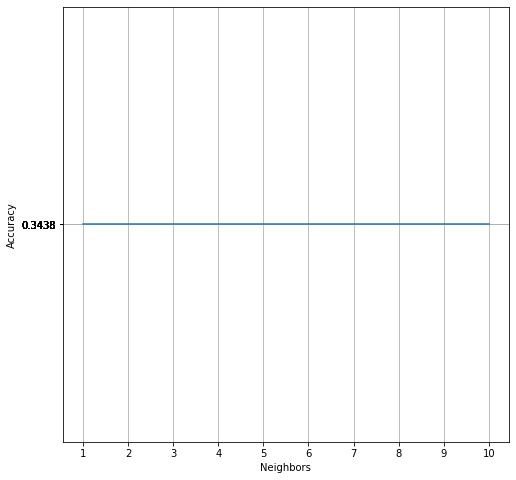

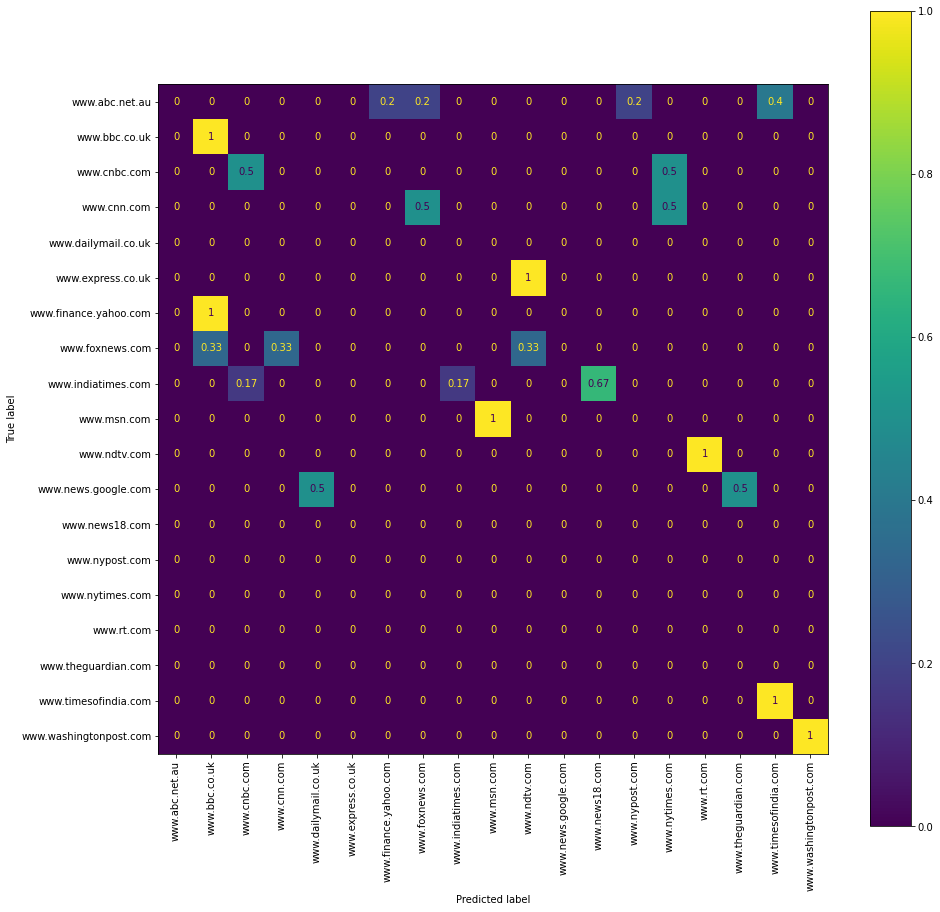

In [69]:
MAX_neighbors = 10
ACCURACY_first_3, PREDICTIONS_first_3, Y_test_first_3 = knn_classifier(MAX_neighbors, first_dataset(3))
first_accuracy_max_3 = ACCURACY_first_3[np.argmax(ACCURACY_first_3)]
accuracy_neighbors_graph(ACCURACY_first_3, MAX_neighbors)
ConfusionMatrixDisplay_fun(ACCURACY_first_3, PREDICTIONS_first_3, Y_test_first_3)

**COMMENT OF THE RESULTS WITH DIFFERENT TEST SET EXECUTED IN DIFFERENT DAYS**

We can notice that using test sets coming from different days we will obtain different features (max_iat, max_pkt_size, mean_iat, etc...).
The reason behind that is that we are performing requests to news websites, that are full of media content and high dynamic.
The content of a GET request executed in one day will be totally different compared to the content of another executed on another day.

We can notice moreover that the performance of the test executed with only 3 requests for each website is worse compared to the one with 10 requests for each website.
The reason behind that is clear, we have fewer tests that we can use to train our model, so the prediction accuracy cannot be so high.

**EXTRA**: Download "**captures**" and "**curl_logs**" folders

In [ ]:
!zip -r /content/captures.zip /content/captures
!zip -r /content/curl_logs.zip /content/curl_logs

from google.colab import files
files.download("/content/curl_logs.zip")
files.download("/content/captures.zip")

**BONUS POINT**

In [71]:
import pandas as pd
from os import listdir
from os.path import isfile, join
import numpy as np
from google.colab import drive
from scipy import interpolate

def extract_p(df_flow):
  src_ip_octets = str(df_flow.item(4)).split('.')
  if(src_ip_octets[0]=='10' or (src_ip_octets[0]=='172' and src_ip_octets[1]>='16' and src_ip_octets[1]<='31') 
  or (src_ip_octets[0]=='192' and src_ip_octets[1]=='168')):
    # p>0 download, incoming packet
    return df_flow.item(2)
  else:
    # p<0 upload, outcoming packet
    return -df_flow.item(2)

def second_dataset():
  #drive.mount('/content/drive')
  #path = '/content/drive/MyDrive/Colab Notebooks/Last with ack info'
  path = '/content/captures'
  dumpfiles = [f for f in listdir(path) if (isfile(join(path, f)))]
  websites = np.unique([f.split('_')[1] for f in dumpfiles])
  #print(websites, len(websites), len(dumpfiles))

  dataset = pd.DataFrame()
  for f in dumpfiles:
    if ".pcap" in f:
      continue
    df = pd.read_csv(join(path, f))
    # Discard ACK packets
    df_no_ack = df[df['tcp.len']!=0]

    C = []
    for df_flow in df_no_ack.values: 
      p = extract_p(df_flow)
      C.append(p)

    for idx1, p1 in enumerate(C):
      if (idx1 == len(C)-1):
        break
      C[idx1+1]+=C[idx1]

    x = np.linspace(0, 19, num=len(C))
    line = interpolate.interp1d(x, C)


    features = {}
    features['website'] = f.split('_')[1]
    for m in range(0,20):
      features["C="+str(m)] = line(m)
    dataset = dataset.append(features, ignore_index=True)

  return dataset

second_dataset_var = second_dataset()
display(second_dataset_var)

,website,C=0,C=1,C=2,C=3,C=4,C=5,C=6,C=7,C=8,...,C=10,C=11,C=12,C=13,C=14,C=15,C=16,C=17,C=18,C=19
0,www.rt.com,689.0,2149.2631578947367,3900.315789473684,4566.368421052632,4889.421052631579,6039.0526315789475,7548.263157894737,7842.473684210527,7767.789473684211,...,4828.105263157895,5034.105263157895,5213.473684210527,5306.684210526316,4730.736842105263,4501.0526315789475,-4293.789473684211,-6389.526315789479,-14118.26315789474,-33431.0
1,www.dailymail.co.uk,832.0,1371.578947368421,1968.3157894736842,2717.4736842105262,3320.7368421052633,3802.421052631579,4284.105263157895,4758.263157894737,5157.157894736842,...,6337.842105263158,6838.8421052631575,7237.736842105262,7315.578947368421,7361.315789473684,7407.0526315789475,7385.684210526316,7283.789473684211,7165.0526315789475,7040.0
2,www.indiatimes.com,744.0,5943.736842105263,9672.894736842105,13067.21052631579,16500.78947368421,19364.84210526316,22681.947368421053,17480.473684210527,17779.57894736842,...,-13412.894736842109,-31376.52631578948,-49573.578947368456,-85338.21052631583,-118206.84210526316,-162955.84210526317,-235682.5789473684,-294570.52631578944,-355004.0,-465836.0
3,www.rt.com,832.0,2281.8947368421054,3536.315789473684,3817.4736842105262,4201.368421052632,5596.21052631579,6873.0526315789475,6979.894736842105,6862.157894736842,...,3939.421052631579,4135.421052631579,4305.894736842105,4480.263157894737,4016.9473684210525,3519.315789473684,-5904.473684210526,-6689.105263157895,-20651.57894736841,-35842.0
4,www.dailymail.co.uk,832.0,1138.5263157894738,1445.0526315789473,1762.1052631578946,2105.4736842105262,2448.842105263158,2771.157894736842,3077.684210526316,3384.2105263157896,...,4313.368421052632,4758.263157894737,5012.105263157894,5265.9473684210525,5596.368421052631,6028.894736842105,6461.421052631579,6766.315789473684,7020.1578947368425,7274.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,www.news18.com,834.0,5498.0,7559.0,2655.0,2437.0,-9390.0,-25684.0,-43456.0,-65575.0,...,-131699.0,-165041.0,-198383.0,-250907.0,-290788.0,-336072.0,-408868.0,-520760.0,-626860.0,-732894.0
196,www.cnn.com,834.0,4364.421052631579,7328.105263157895,7247.78947368421,2568.5263157894738,2813.315789473684,-316.63157894736696,-16982.73684210526,-33648.84210526315,...,-74505.05263157895,-117406.73684210524,-180037.26315789472,-246027.36842105264,-335121.47368421056,-437059.57894736825,-552373.6842105264,-683495.789473684,-801849.8947368418,-920204.0
197,www.theguardian.com,832.0,1138.5263157894738,1445.0526315789473,1751.578947368421,2058.1052631578946,2364.6315789473683,2692.2105263157896,3035.5789473684213,3378.947368421053,...,4231.263157894737,4638.263157894737,4892.105263157894,5145.9473684210525,5495.315789473683,5972.0526315789475,6448.789473684211,6766.315789473684,7020.1578947368425,7274.0
198,www.ndtv.com,834.0,3835.6842105263154,6118.526315789473,7603.315789473684,7950.631578947368,4010.2631578947367,4403.9473684210525,3644.6315789473683,-4521.421052631578,...,-24032.57894736842,-33940.57894736842,-43238.8947368421,-60062.94736842104,-80411.78947368418,-105257.05263157892,-130635.7894736842,-150222.5263157895,-181545.68421052623,-224206.0


**BONUS POINT** - **k-NN** classifier

In [72]:
MAX_neighbors=10
ACCURACY_second, PREDICTIONS_second, Y_test_second = knn_classifier(MAX_neighbors, second_dataset_var)

1 0.4
2 0.4166666666666667
3 0.4166666666666667
4 0.4
5 0.36666666666666664
6 0.4
7 0.4
8 0.38333333333333336
9 0.38333333333333336
10 0.36666666666666664


**BONUS POINT** - **Accuracy-Neighbors** graph

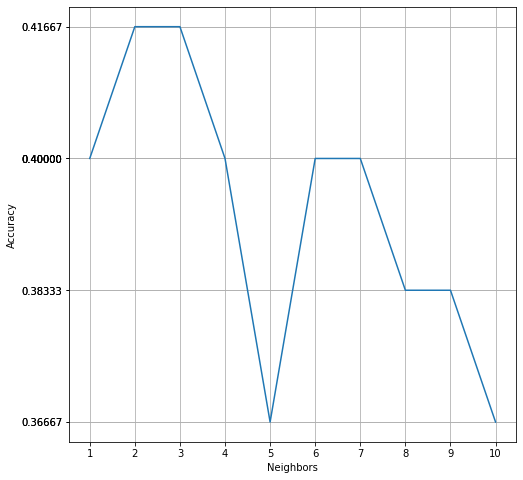

In [73]:
accuracy_neighbors_graph(ACCURACY_second, MAX_neighbors)

**BONUS POINT** - **ConfusionMatrixDisplay** with the highest level of accuracy

ConfusionMatrixDisplay for k=1 accuracy=0.4166666666666667



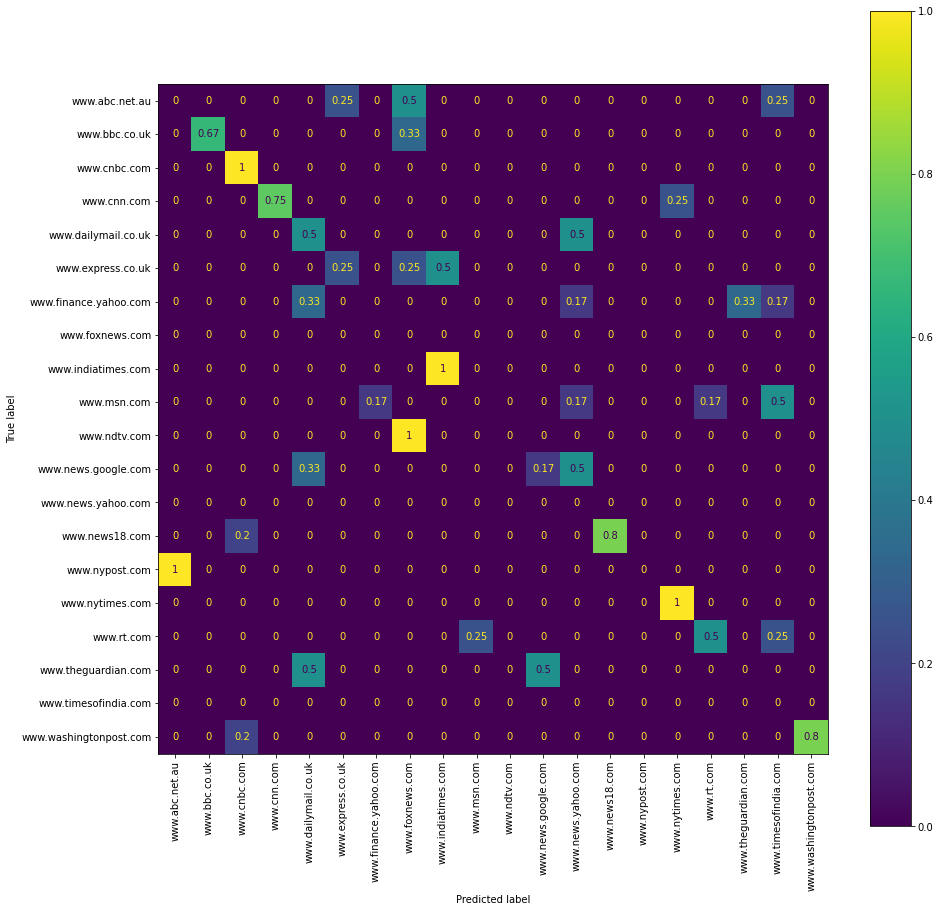

In [74]:
ConfusionMatrixDisplay_fun(ACCURACY_second, PREDICTIONS_second, Y_test_second)

**COMPARE THE RESULTS WITH THE PREVIOUS APPROACH**

In [75]:
first_10 = 0
first_3 = 0
second = 0

tests = 100
for _ in range(0,tests):
  MAX_neighbors = 10
  ACCURACY_first_10, PREDICTIONS_first_10, Y_test_first_10 = knn_classifier(MAX_neighbors, first_dataset(10))
  first_accuracy_max_10 = ACCURACY_first_10[np.argmax(ACCURACY_first_10)]

  ACCURACY_first_3, PREDICTIONS_first_3, Y_test_first_3 = knn_classifier(MAX_neighbors, first_dataset(3))
  first_accuracy_max_3 = ACCURACY_first_3[np.argmax(ACCURACY_first_3)]

  ACCURACY_second, PREDICTIONS_second, Y_test_second = knn_classifier(MAX_neighbors, second_dataset())
  second_accuracy_max = ACCURACY_second[np.argmax(ACCURACY_second)]

  if first_accuracy_max_10 > second_accuracy_max:
    first_10+=1
  elif first_accuracy_max_3 > second_accuracy_max:
    first_3+=1
  elif second_accuracy_max > first_accuracy_max_10 and second_accuracy_max > first_accuracy_max_3:
    second+=1

print("Final score obtained in", tests ,"tests:\n\t-First method (10) better than second: "+str(first_10)+"\n\t-First method (3) better than second: "+str(first_3)+"\n\t-Second method better: "+str(second))


1 0.5384615384615384
2 0.5384615384615384
3 0.5480769230769231
4 0.5576923076923077
5 0.5480769230769231
6 0.5576923076923077
7 0.5673076923076923
8 0.5480769230769231
9 0.5480769230769231
10 0.5576923076923077
1 0.375
2 0.375
3 0.375
4 0.40625
5 0.40625
6 0.40625
7 0.40625
8 0.40625
9 0.40625
10 0.40625
1 0.5333333333333333
2 0.5333333333333333
3 0.55
4 0.5166666666666667
5 0.5
6 0.5
7 0.4666666666666667
8 0.45
9 0.4666666666666667
10 0.45
1 0.5384615384615384
2 0.5384615384615384
3 0.5673076923076923
4 0.5673076923076923
5 0.5673076923076923
6 0.5480769230769231
7 0.5192307692307693
8 0.5096153846153846
9 0.5288461538461539
10 0.5673076923076923
1 0.28125
2 0.28125
3 0.25
4 0.25
5 0.21875
6 0.21875
7 0.21875
8 0.21875
9 0.21875
10 0.21875
1 0.6166666666666667
2 0.6333333333333333
3 0.5666666666666667
4 0.5666666666666667
5 0.55
6 0.5333333333333333
7 0.55
8 0.5333333333333333
9 0.5166666666666667
10 0.55
1 0.5769230769230769
2 0.5769230769230769
3 0.5673076923076923
4 0.5769230769230

In the executed tests we generally notice that the accuracy of the first method (10 requests) that uses features like max_iat, max_pkt_size, mean_iat, etc..., is slightly greater than the second method (10 requests) which uses cumulative traffic. This happens in most of the tests carried out but not in all, so we cannot say for sure that the first method is better in every case.
In 100 analyzed tests, I retrieved these results:


*   First method (10 requests): 85 tests with better max accuracy compared to the second method (10 requests)
*   First method (3 requests): 0 tests with better max accuracy compared to the second method (10 requests)
*   Second method (10 requests): 15 test with better max accuracy

